
# Seattle City Light Landslide Model 

Here we explore groundwater-driven shallow landsliding in the Skagit River Watershed above the confluence with Sauk River. 

This Jupyter Notebook runs the Landlab LandslideProbability component on a 30-m digital elevation model (DEM) using depth to groundwater from the Distributed Hydrology Soil and Vegetation (DHSVM) hydrologic model.

This notebook performs the following functions:<br >
1) Import libraries and set HydroShare variables<br />
2) Review data needed as input for the landslide model<br />
3) Create a RasterModelGrid based on a 30-m DEM<br />
4) Access and assign data fields used to calculate landslide probability<br />
5) Set Number of iterations to run Monte Carlo simulation<br />
6) Specify goundwater option as _data driven spatial_ and access NetCDF to generate groundwater depth distributions<br /> 
7) Run Landlab LandslideProbability component<br /> 
8) Adjust root cohession to simulate fire and run Landlab LandslideProbability Component<br />
9) Display and visualize results of stability analysis<br /> 
<br /> 


## To run this Python3 notebook:

To run this example, click in each shaded cell below and "shift + enter" to run each cell. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting you run option. This is also where you can clear outputs from previous runs.

If an error occurs, try "Restart" the kernel by clicking "Kernel" on the menu above. Select Python 3 kernal. 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading. and creation. Additional libraries support the functions of Landlab.

### Import libraries

In [22]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import itertools


#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
homedir = os.getcwd()
print('Data will be loaded from and saved to:'+homedir)
os.chdir('/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents')
print(homedir)

Successfully established a connection with HydroShare
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents


#import Python utilities for calculating and plotting
import six

import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import warnings
print('Ignore deprecation warnings')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)



# Import Landlab libraries
import landslide_probability
from landslide_probability_20191122 import LandslideProbability
from landlab import RasterModelGrid
from landlab import imshow_grid_at_node
# from landlab.plot.imshow import imshow_node_grid
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from collections import defaultdict
from landlab.io.netcdf import read_netcdf
from landlab.io.netcdf import write_netcdf

import time
st = time.time()

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### Import data
 This data was preprocessed for the Seattle City Light case study and is on HydroShare as [Depth to Water Table Spatial Distributions for Skagit Landslide Hazards](https://www.hydroshare.org/resource/767e35f896a94023b25f788701bad641/).
Click on the link to see the data repository on HydroShare for more information and citation.

Set a variable name for the data resource using the HydroShare resource ID.

In [23]:
Data_ResourceID='767e35f896a94023b25f788701bad641'

Execute the next cell to download data from another HydroShare resource - this may take a minute.

In [24]:
hs.getResourceFromHydroShare(Data_ResourceID)
data_folder = '/home/jovyan/work/notebooks/data/'+ Data_ResourceID +'/'+Data_ResourceID+'/data/contents/'
print('This is the location on the HydroShare JupyterHub server where the data has just been downloaded:')


This resource already exists in your userspace.
767e35f896a94023b25f788701bad641/
|-- 767e35f896a94023b25f788701bad641/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- dtw_DHSVMoutput_20190502.tar
|   |   |   |-- grids.pkl
|   |   |   |-- plot_xrvis.ipynb
|   |   |   |-- process_wt_grids.py
|   |   |   |-- process_wt_grids_with_vis.py
|   |   |   |-- .ipynb_checkpoints/

Do you want to overwrite these data [Y/n]? n


This is the location on the HydroShare JupyterHub server where the data has just been downloaded:


 ## 2. Process DHSVM outputs

Use terminal recording below by removing the comments and executing in Notebook, or open a terminal to move and extract data from the Resource ID folder to your working directory. Check the list of data that has been transferred to your use space. 

File management for DHSVM model outputs

In [25]:
#!ls
#!cp ../../../../767e35f896a94023b25f788701bad641/767e35f896a94023b25f788701bad641/data/contents/dtw_DHSVMoutput_20190502.tar .
#!pwd
#!ls
#!tar -xvf dtw_DHSVMoutput_20190502.tar
#!gunzip -r dtw_DHSVMoutput_20190502/*

In [26]:
path_historic='dtw_DHSVMoutput_20190502/output_SCLlandslide_historic/Map.Soil.TableDepth.asc'


Import depth to water table and storm/saturation event dates
DHSVM output file is Grid Rows X Dates printed = Rows


In [27]:
values = np.loadtxt(path_historic)

In [28]:
print(values.shape)

(44880, 916)


### TO DO: These need to be converted to dates, not stings saved with a date label

In [29]:
path_dates = 'export_historic_dates'
dates = pd.read_csv(path_dates, sep=" ", header=None)
dates.columns = ["Map", "txt", "number", "date"] 
#dates['date']
#dates

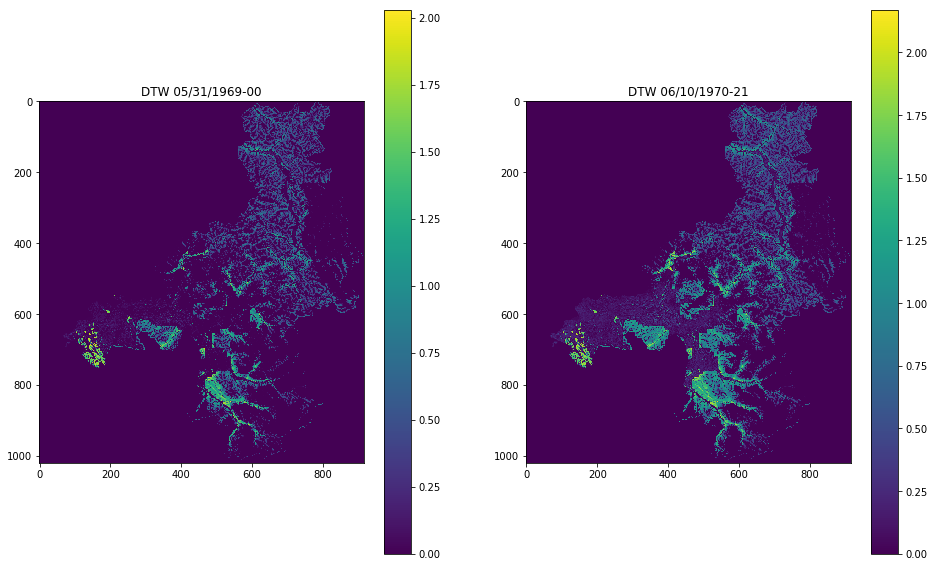

In [30]:
no_time = values.shape[0]/1020
first_date = values[:1020]
second_date = values[1020:2040]

fig = plt.figure(figsize=(16,10))

#plot one image to check 
ax1 = fig.add_subplot(121)
ax1.set_title('DTW '+dates['date'][0])
plt.imshow(first_date)
ax1.set_aspect('equal')

plt.colorbar(orientation='vertical')

ax2 = fig.add_subplot(122)
ax2.set_title('DTW '+dates['date'][1])
plt.imshow(second_date)
ax2.set_aspect('equal')

plt.colorbar(orientation='vertical')

plt.show()

File management for List of UTM values for 150m and 30m grid maps path_grids

In [31]:
#!cp ../../../../767e35f896a94023b25f788701bad641/767e35f896a94023b25f788701bad641/data/contents/grids.pkl .

### TO DO: Describe where this came from and how it was created

In [32]:
path_grids='grids.pkl'
with open(path_grids, 'rb') as f:
    grids = pickle.load(f)

In [33]:
print(grids.keys())
print(grids['X_'].shape) #Skagit domain 150m grid cell ROWS
print(grids['X_1'].shape) #SCL domain 30m grid cell COLS
print(grids['Y_'].shape) #Skagit domain 150m grid cell ROWS
print(grids['Y_1'].shape) #SCL domain 30m grid cell COLS
print(grids['X_1'][0][0])  #top left
print(grids['X_1'][1][2724]) #bottom right

dict_keys(['X_', 'X_1', 'Y_', 'Y_1'])
(1020, 916)
(2720, 2725)
(1020, 916)
(2720, 2725)
591330
673050


In [34]:
grids['Y_']

array([[5464320, 5464320, 5464320, ..., 5464320, 5464320, 5464320],
       [5464170, 5464170, 5464170, ..., 5464170, 5464170, 5464170],
       [5464020, 5464020, 5464020, ..., 5464020, 5464020, 5464020],
       ...,
       [5311770, 5311770, 5311770, ..., 5311770, 5311770, 5311770],
       [5311620, 5311620, 5311620, ..., 5311620, 5311620, 5311620],
       [5311470, 5311470, 5311470, ..., 5311470, 5311470, 5311470]],
      dtype=int32)

### TO DO: Understand and explain why these numbers are different than printed above - see Ronda - please add how you got these numbers. Landlab lookup?

corners (lon, lat)

bottom left: 591315, 5354895 (node 0)

bottom right: 673065, 5354895 (node 2724)

top left: 591315, 5436495 (node 7409274)

top right: 673065, 5436495 (node 7411999)


These are the true corners and lon/lat for grid cell center is 15m different.

This confirms that the first x(lon) and y(lat) is the upper left corner in the data 
and flippy makes it the same as the landlab grid.

### 2. Split and Arrange
#### Skagit DHSVM Basin Domain: 916 rows x 1020 columns

In [35]:
list_arrays = np.vsplit(values, no_time)
all_arrays =  np.asarray(list_arrays)

In [36]:
print(all_arrays.shape)

(44, 1020, 916)


In [37]:
num = dates['date'].size

years = np.linspace(1, no_time, num)

x_ = np.linspace(1, 916, num = 916)

y_ = np.linspace(1, 1020, num = 1020)

print('Dimensions of 150m Skagit DHSVM Domain Grid')
print(x_.shape)
print(y_.shape)

Dimensions of 150m Skagit DHSVM Domain Grid
(916,)
(1020,)


In [38]:
#test interpolation
x = grids["X_"][:1]
y = grids["Y_"][:, 1:2]
print('Dimensions of 150m Skagit DHSVM Domain Grid')
print(x.shape)
print(y.shape)
y[0]

Dimensions of 150m Skagit DHSVM Domain Grid
(1, 916)
(1020, 1)


array([5464320], dtype=int32)

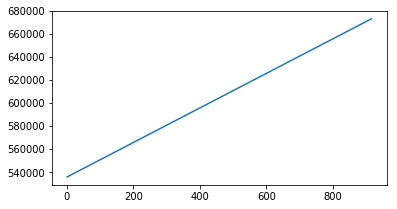

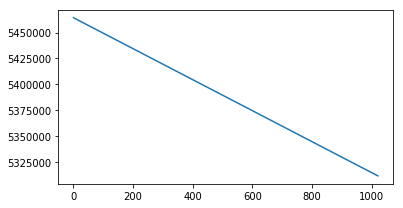

In [39]:
fig = plt.figure(figsize=(6, 3.2))
plt.plot(x_, x.T)
fig = plt.figure(figsize=(6, 3.2))
plt.plot(y_, y)

In [40]:
x1_ = np.linspace(1, 916, num = 2725)
y1_ = np.linspace(1, 916, num = 2720)

x1 = grids["X_1"][:1]
y1 =grids["Y_1"][:, 1:2]

# check grids 
x1 = x1.T
t = y_.shape
y = y.reshape(t) 
t = x_.shape
x = x.reshape(t) 

In [41]:
print('Dimensions of 30m SCL Domain Grid x=rows=2725; y=cols=2720')
print(x1_.shape)
print(y1_.shape)
print('Dimensions of 150m Skagit Model Grid')
print(x.shape)
print(y.shape)

Dimensions of 30m SCL Domain Grid x=rows=2725; y=cols=2720
(2725,)
(2720,)
Dimensions of 150m Skagit Model Grid
(916,)
(1020,)


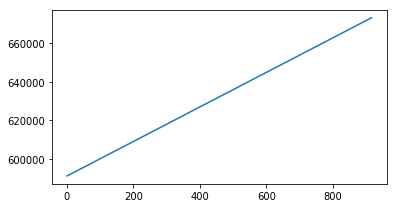

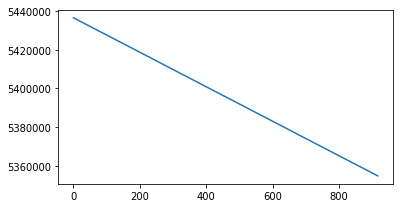

In [42]:
fig = plt.figure(figsize=(6, 3.2))
plt.plot(x1_, x1)
fig = plt.figure(figsize=(6, 3.2))
plt.plot(y1_, y1)

## 3. Create xarray datasets of 150m Grid

#### Load  Dataset

In [43]:
ds_wt = xr.Dataset(data_vars = {'wt': (('time', 'y', 'x'), all_arrays)})
ds_wt['time'] = dates["date"].tolist()
ds_wt['y'] = y
ds_wt['x'] = x

### To Do: Check time list - note that xarray doesn't see this as time, it is a list of strings until we update it above.

In [44]:
ds_wt['time']

<xarray.DataArray 'time' (time: 44)>
array(['05/31/1969-00', '06/10/1970-21', '06/25/1971-21', '06/11/1972-12',
       '06/25/1973-21', '06/19/1974-15', '06/15/1975-15', '12/04/1975-21',
       '06/08/1977-18', '12/15/1977-18', '06/05/1979-21', '12/21/1979-00',
       '06/22/1981-06', '06/20/1982-15', '07/15/1983-06', '06/30/1984-18',
       '06/08/1985-15', '11/06/1985-21', '05/14/1987-21', '05/29/1988-18',
       '06/14/1989-15', '12/08/1989-21', '11/25/1990-15', '12/09/1991-21',
       '06/01/1993-21', '05/29/1994-21', '06/06/1995-15', '12/01/1995-18',
       '07/10/1997-15', '05/27/1998-18', '06/25/1999-18', '06/14/2000-15',
       '06/12/2001-21', '06/06/2002-18', '06/10/2003-15', '10/23/2003-00',
       '05/20/2005-21', '06/08/2006-15', '11/16/2006-21', '06/05/2008-18',
       '06/02/2009-15', '06/10/2010-15', '06/15/2011-15', '11/28/2011-21'],
      dtype='<U13')
Coordinates:
  * time     (time) <U13 '05/31/1969-00' '06/10/1970-21' ... '11/28/2011-21'

### Verify that netcdf formatted files are correctly oriented

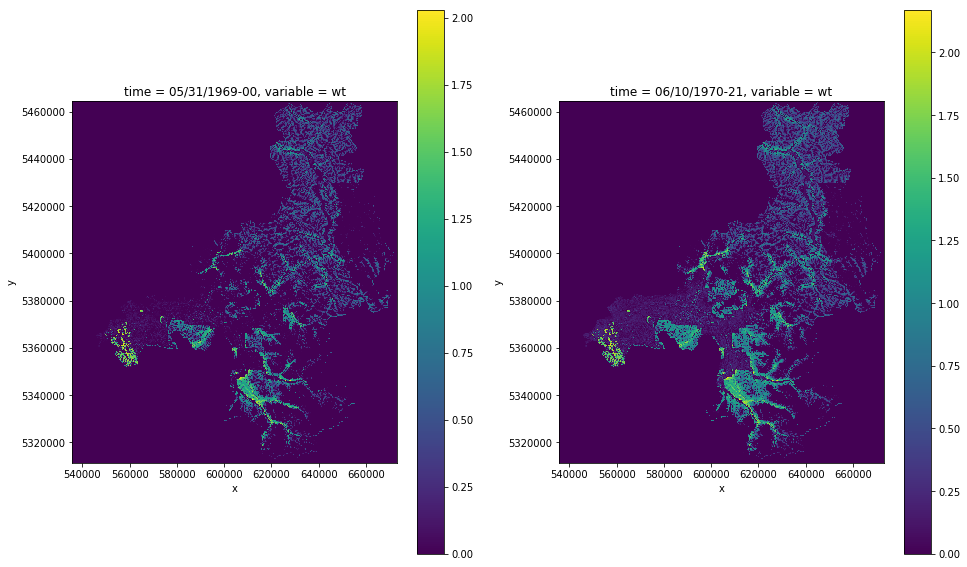

In [45]:

fig = plt.figure(figsize=(16,10))

#plot one image to check 
ax1 = fig.add_subplot(121)
ax1.set_title('DTW '+dates['date'][0])
ds_wt.isel(time=[0]).to_array().plot() #shows upsidedown than imshow
ax1.set_aspect('equal')

ax2 = fig.add_subplot(122)
ax2.set_title('DTW '+dates['date'][1])
ds_wt.isel(time=[1]).to_array().plot() #shows upsidedown than imshow
ax2.set_aspect('equal')


## 4. Reshape 150m grid to 30m 



In [46]:
print(y1.shape)
print(x1.shape)
print(x1[0])
y1[0] #top
x1[0]

(2720, 1)
(2725, 1)
[591330]


array([591330], dtype=int32)

In [47]:
y1 = y1.reshape(y1.shape[0])
x1 = x1.reshape(x1.shape[0])
dsi = ds_wt.interp(y = y1, x = x1)

In [48]:
dsi

<xarray.Dataset>
Dimensions:  (time: 44, x: 2725, y: 2720)
Coordinates:
  * time     (time) <U13 '05/31/1969-00' '06/10/1970-21' ... '11/28/2011-21'
  * y        (y) int32 5436480 5436450 5436420 ... 5354970 5354940 5354910
  * x        (x) int32 591330 591360 591390 591420 ... 672990 673020 673050
Data variables:
    wt       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan nan

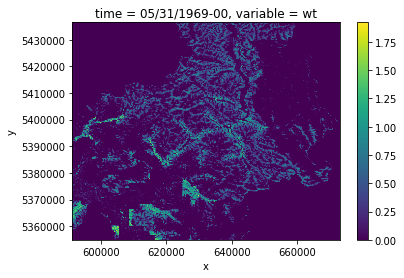

In [49]:
dsi.isel(time=[0]).to_array().plot() 

### To Do: This plotting won't work with stings as dates

In [50]:
#dsi.isel(x=[0],y = [0]).to_array().plot() #shows upsidedown than imshow
dsloc1 =dsi.sel(x=5436480 ,y=591330,method='nearest')
dsloc1 =dsi.sel(x=5436480 ,y=591330,method='nearest')
#dsloc1['wt'].plot.line('b-',figsize=(15,10))
dsloc1

<xarray.Dataset>
Dimensions:  (time: 44)
Coordinates:
  * time     (time) <U13 '05/31/1969-00' '06/10/1970-21' ... '11/28/2011-21'
    y        int32 5354910
    x        int32 673050
Data variables:
    wt       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

### Save Dictionary of Hydrologic Forcings

In [51]:
one_location = ds_wt.isel(x=[600], y = [500]).to_array()
one_location

<xarray.DataArray (variable: 1, time: 44, y: 1, x: 1)>
array([[[[0.902598]],

        [[1.291265]],

        [[0.991959]],

        [[0.647137]],

        [[1.326499]],

        [[1.002995]],

        [[1.086256]],

        [[0.664288]],

        [[1.300401]],

        [[0.99507 ]],

        [[1.112424]],

        [[0.889727]],

        [[1.172803]],

        [[0.968163]],

        [[1.17258 ]],

        [[1.318577]],

        [[0.991071]],

        [[0.810555]],

        [[1.070451]],

        [[1.134643]],

        [[1.299168]],

        [[0.852313]],

        [[0.634248]],

        [[0.929899]],

        [[1.204837]],

        [[1.257334]],

        [[1.059748]],

        [[0.496929]],

        [[0.84696 ]],

        [[1.180833]],

        [[0.925001]],

        [[0.984661]],

        [[1.255264]],

        [[0.816451]],

        [[1.381311]],

        [[0.771452]],

        [[1.279763]],

        [[1.254019]],

        [[0.76078 ]],

        [[0.753213]],

        [[0.95703 ]],

  

In [52]:
number_of_nodes=7412000
keys=np.arange(number_of_nodes)


In [53]:
keys

array([      0,       1,       2, ..., 7411997, 7411998, 7411999])

In [54]:
#test no loop ON DHSVM grid
HSD_dict_annualmaxDWT={}
for i in range(10):
       one_location=ds_wt.isel(x=[600], y = [500]).to_array()
       loc1list=np.array(one_location.variable)
       b = list(itertools.chain(*loc1list))
       c = list(itertools.chain(*b))
       d = list(itertools.chain(*c))
       HSD_dict_annualmaxDWT[i] = {keys[i]:d} 
    

In [55]:
HSD_dict_annualmaxDWT

{0: {0: [0.902598,
   1.291265,
   0.991959,
   0.647137,
   1.326499,
   1.002995,
   1.086256,
   0.664288,
   1.300401,
   0.99507,
   1.112424,
   0.889727,
   1.172803,
   0.968163,
   1.17258,
   1.318577,
   0.991071,
   0.810555,
   1.070451,
   1.134643,
   1.299168,
   0.852313,
   0.634248,
   0.929899,
   1.204837,
   1.257334,
   1.059748,
   0.496929,
   0.84696,
   1.180833,
   0.925001,
   0.984661,
   1.255264,
   0.816451,
   1.381311,
   0.771452,
   1.279763,
   1.254019,
   0.76078,
   0.753213,
   0.95703,
   1.237507,
   0.69135,
   1.213077]},
 1: {1: [0.902598,
   1.291265,
   0.991959,
   0.647137,
   1.326499,
   1.002995,
   1.086256,
   0.664288,
   1.300401,
   0.99507,
   1.112424,
   0.889727,
   1.172803,
   0.968163,
   1.17258,
   1.318577,
   0.991071,
   0.810555,
   1.070451,
   1.134643,
   1.299168,
   0.852313,
   0.634248,
   0.929899,
   1.204837,
   1.257334,
   1.059748,
   0.496929,
   0.84696,
   1.180833,
   0.925001,
   0.984661,
   1.25

In [76]:
HSD_dict_annualmaxDWT_hist={}
counter=0
for j in np.arange(1500,1600):
    for k in np.arange(1500,1600):
            one_location=dsi.isel(x=[j],y=[k]).to_array()
            loc1list=np.array(one_location.variable)
            b = list(itertools.chain(*loc1list))
            c = list(itertools.chain(*b))
            d = list(itertools.chain(*c))
            HSD_dict_annualmaxDWT_hist[counter] = {keys[counter]:d} 
            counter=counter+1

In [79]:
dsi.isel(x=[1500],y=[1600])

<xarray.Dataset>
Dimensions:  (time: 44, x: 1, y: 1)
Coordinates:
  * time     (time) <U13 '05/31/1969-00' '06/10/1970-21' ... '11/28/2011-21'
  * y        (y) int32 5388480
  * x        (x) int32 636330
Data variables:
    wt       (time, y, x) float64 0.07133 0.119 0.07228 ... 0.1388 0.1969 0.4555

In [81]:
HSD_dict_annualmaxDWT_hist[9]


{9: [0.00012096,
  0.00014688,
  0.00049236,
  0.0,
  0.07373292,
  0.00011483999999999999,
  0.00041903999999999997,
  0.09398051999999998,
  0.00097392,
  0.4614642,
  0.00016968,
  0.4796784,
  0.00066948,
  0.00011483999999999999,
  0.00054264,
  0.0001206,
  0.0005813999999999999,
  0.27540564,
  0.01756128,
  0.02007588,
  0.0061648,
  0.08923848000000001,
  0.00243708,
  0.31863748,
  0.00546036,
  0.00043391999999999997,
  0.0004990799999999999,
  0.019197719999999998,
  0.00138384,
  0.03338604,
  0.00050148,
  0.00028440000000000003,
  0.00081312,
  0.01177536,
  0.0008414,
  0.01820256,
  0.0024110399999999997,
  0.00027612,
  0.149819,
  0.062124120000000005,
  0.03767016,
  0.00042984,
  0.00044196,
  0.327848]}

In [36]:
#HSD_dict_annualmaxDWT_hist={}
#counter=0
#for j in range(len(x)):
#    for k in range(len(y)):
#            one_location=dsi.isel(x=[j],y=[k]).to_array()
#            loc1list=np.array(one_location.variable)
#            b = list(itertools.chain(*loc1list))
#            c = list(itertools.chain(*b))
#            d = list(itertools.chain(*c))
#            HSD_dict_annualmaxDWT_hist[counter] = {keys[counter]:d} 
#            counter=counter+1

In [ ]:

with open('HSD_dict_annualmaxDWT_hist.pkl', 'w') as output:
    pickle.dump(HSD_dict_annualmaxDWT_hist, output)
    

